# Problem 1 - Digit Recognizer

### Imports

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import tensorflow as tf 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings, math
import time
from scipy.stats import entropy
warnings.filterwarnings("ignore")

### The dataset

In [2]:
data = np.load('dataset.npz')
X = data['X']
y = data['y']

labels_dict = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'A',
    11: 'B',
    12: 'C',
    13: 'D',
    14: 'E',
    15: 'F',
    16: 'Empty'
}

### Splitting the dataset

In [3]:
seed = 13
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

### Visualizing data

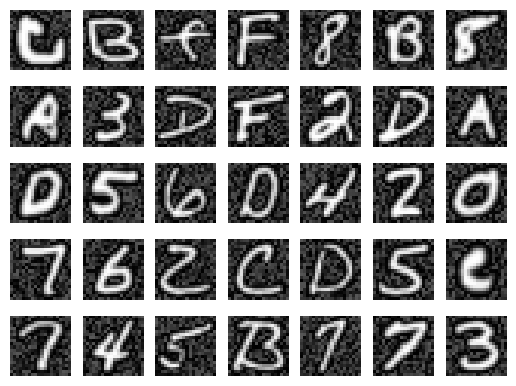

In [16]:
fig, axes = plt.subplots(5, 7)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
    ax.axis('off')
plt.show()

### Visualizing data by class

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(6, 6))
axes = axes.ravel()
np.random.seed(42)

for class_label in range(17):
    class_indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(class_indices)
    
    axes[class_label].imshow(X_train[random_index].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
    axes[class_label].axis('off')
    axes[class_label].set_title(labels_dict[class_label])
     
axes[-1].axis('off')
plt.tight_layout()
plt.show()

### Data Preprocessing

In [4]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_norm)
X_test = scaler.transform(X_test_norm)

### Model selection - Classifier 1

Here I use SVM

In [5]:
param_grid = {
    'C': [0.1, 1, 10], 
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

grid_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train, y_train)

print("Best parameters for SVM:", grid_svc.best_params_)
best_svc = grid_svc.best_estimator_

y_pred_svc = best_svc.predict(X_test)
print(f"SVM Classification Report:\n{classification_report(y_test, y_pred_svc)}")

Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       188
           1       0.92      0.96      0.94        69
           2       0.94      0.89      0.91       158
           3       0.94      0.95      0.94       285
           4       0.90      0.90      0.90       150
           5       0.93      0.89      0.91       209
           6       0.96      0.96      0.96       274
           7       0.92      0.95      0.93       182
           8       0.87      0.85      0.86       128
           9       0.95      0.87      0.91        61
          10       0.91      0.94      0.92       248
          11       0.87      0.83      0.85       157
          12       0.94      0.98      0.96       285
          13       0.88      0.92      0.90       273
          14       1.00      0.55      0.71        22
          15       0.87      0.87      

### Model selection - Classifier 2

Here I use Random forest

In [6]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7]
}

grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, y_pred_rf)}")

Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       188
           1       0.88      0.84      0.86        69
           2       0.92      0.59      0.72       158
           3       0.71      0.94      0.81       285
           4       0.79      0.78      0.79       150
           5       0.81      0.66      0.72       209
           6       0.80      0.92      0.86       274
           7       0.75      0.92      0.83       182
           8       0.74      0.56      0.64       128
           9       1.00      0.15      0.26        61
          10       0.70      0.94      0.80       248
          11       0.81      0.46      0.59       157
          12       0.75      0.97      0.85       285
          13       0.77      0.81      0.79       273
          14       0.00      0.00      0.00        22
          15       0.81  

### Model selection - Classifier 3

Here i use neaural network. Inspired by this article from medium [handwritten-digit-recognition](https://medium.com/@azkardm/handwritten-digit-recognition-4dc904edb515).

In [76]:
start_time = time.time()
num_class = len(labels_dict)

# reshape data
X_train_tf = X_train.reshape(-1, 20, 20)
X_test_tf = X_test.reshape(-1, 20, 20)

# Layers
model_nn = tf.keras.models.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=(20, 20)),
    # hidden layers
    tf.keras.layers.Reshape((20, 20, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # Output layer
    tf.keras.layers.Dense(num_class, activation='softmax')
])

# Compile the model
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model_nn.fit(X_train_tf, y_train, epochs=10)

# Evaluate the model
loss, nn_accuracy = model_nn.evaluate(X_test_tf, y_test)

end_time = time.time()
print(f"Running time: {(end_time - start_time):0.3f}")


Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6723 - loss: 1.0979
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9322 - loss: 0.2264
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.1114
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9798 - loss: 0.0666
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9903 - loss: 0.0365
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9863 - loss: 0.0440
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9962 - loss: 0.0168
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0265
Epoch 9/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0121
Epoch 10/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9948 - loss: 0.0131
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9641 - loss: 0.1962
Running time: 6.764


### Classifier Evaluation

In [79]:
svc_accuracy = accuracy_score(y_test, y_pred_svc)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"SVM Test Accuracy: {svc_accuracy:0.3f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:0.3f}")
print(f"Neural network Accuracy: {nn_accuracy:0.3f}\n")

accuracies = {
    'SVM': svc_accuracy,
    'Random Forest': rf_accuracy,
    'Neural Network': nn_accuracy
}
best_model_name = max(accuracies, key=accuracies.get)
if best_model_name == 'SVM':
    best_model = grid_rf
elif best_model_name == 'Random Forest':
    best_model = grid_svc
elif best_model_name == 'Neural Network':
    best_model = model_nn

print(f"Best model is {best_model_name} with accuracy: {accuracies[best_model_name] * 100:.2f}%")

SVM Test Accuracy: 0.920
Random Forest Test Accuracy: 0.782
Neural network Accuracy: 0.962

Best model is Neural Network with accuracy: 96.20%


### Vizulize the predicted data with confusion matrix
// Remove before delivering

How to read the table: 
- Take the value at row 0, column 0, which is 140. This means that for 140 instances, the true label was 0, and the classifier also predicted 0.
- Now, look at row 0, column 14, which is 30. This means that for 30 instances, the true label was 0, but the classifier incorrectly predicted label 14. 

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


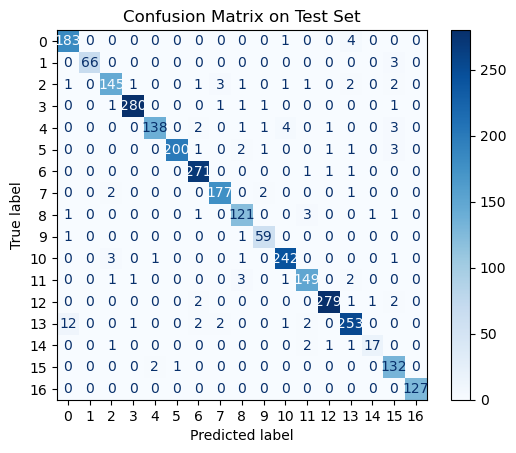

In [80]:
if isinstance(best_model, tf.keras.Model):
    X_test_nn = X_test_tf.reshape(-1, 20, 20, 1) 
    y_pred_probs = best_model.predict(X_test_nn)
    y_pred_test = np.argmax(y_pred_probs, axis=1)
else:
    y_pred_test = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

### Testing the classifier agianst the unseen data

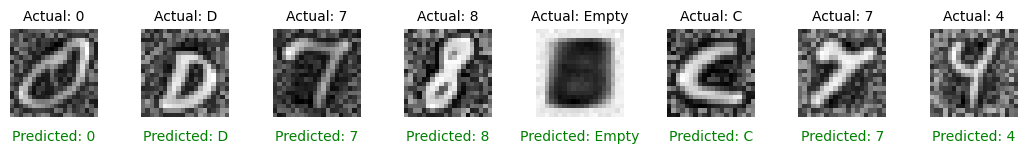

In [81]:
num_samples = 8
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_true_labels = y_test[indices]
sample_predicted_labels = y_pred_svc[indices]

fig, axes = plt.subplots(1, num_samples, figsize=(13, 4))  
for i in range(num_samples):
    ax = axes[i]
    ax.imshow(sample_images[i].reshape(20, 20), cmap='gray')
    ax.axis('off')

    actual = labels_dict[sample_true_labels[i]]
    predicted = labels_dict[sample_predicted_labels[i]]

    if actual == predicted:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(f"Actual: {actual}", fontsize=10)
    ax.text(0.5, -0.15, f"Predicted: {predicted}", fontsize=10, color=color, ha='center', va='top', transform=ax.transAxes)

plt.subplots_adjust(wspace=0.5) 

plt.show()

# Problem 2: Dimensionality Reduction

### Determine Optimal Number of Components

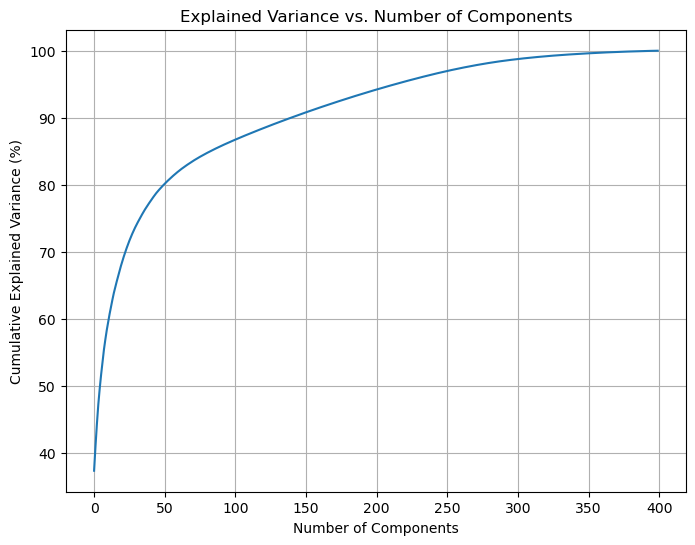

In [18]:
pca = PCA().fit(X_train)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

We can choose $k$ such that we retain, for example, 95% of the variance.

In [90]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

k = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {k}")

Number of components explaining 95% variance: 170


### Transform Data Using PCA

In [91]:
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Train Classifier on Reduced Data

In [92]:
start_time = time.time()

model_pca = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(k,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax')
])


model_pca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_pca.fit(X_train_pca, y_train, epochs=10)

end_time = time.time()
print(f"Running time: {(end_time - start_time):0.3f}")

Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.3483 - loss: 2.1382
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.7562 - loss: 0.7855
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.8294 - loss: 0.5191
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.8534 - loss: 0.4544
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8919 - loss: 0.3486
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.9028 - loss: 0.2979
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.9159 - loss: 0.2555
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.9217 - loss: 0.2342
Epoch 9/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.9335 - loss: 0.2026
Epoch 10/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.9353 - loss: 0.2033
Running time: 3.057


### Evaluate performance

Running time from running non-reduced data was $6.878s$, and is now only $3.058s$. \
But accuracy went from $94.51\%$ to $89.43\%$.

In [93]:
loss, accuracy_pca = model_pca.evaluate(X_test_pca, y_test)

print(f"Accuracy with PCA: {accuracy_pca * 100:.2f}%")
print(f"Accuracy without PCA: {nn_accuracy * 100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.8979 - loss: 0.3635
Accuracy with PCA: 89.90%
Accuracy without PCA: 96.20%


# Problem 3: Detecting Out-of-Distribution Images

### The dataset

In [94]:
corrupted_data = np.load('corrupt_dataset.npz')
X_corrupted = corrupted_data['X']

### Visualisation of the corrupted data

We have normal data, but  it seem to inlcude images of clohtes like pants, sweater, dress too. 

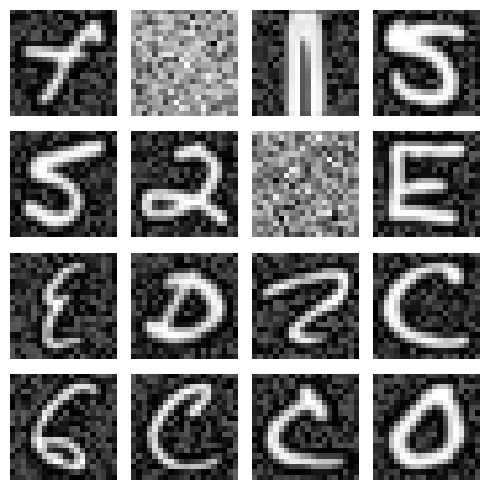

In [95]:
num_images = 16

plt.figure(figsize=(5, 5))
indices = np.random.choice(len(X_corrupted), num_images, replace=False)
for i, idx in enumerate(indices):
    image = X_corrupted[idx].reshape(20, 20)
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Using One-Class SVM to detect outliers

In [121]:
# TODO: Test with others like Isolation Forest,  Local Outlier Factor, ...
X_corrupted_scaled = scaler.transform(X_corrupted)

pca = PCA(n_components=k)
X_corrupted_pca = pca.fit_transform(X_corrupted_scaled)

#poly
ocsvm = OneClassSVM(kernel='poly', gamma='scale', nu=0.88)
ocsvm.fit(X_train_pca)

predictions = ocsvm.predict(X_corrupted_pca)
inlier_indices = np.where(predictions == 1)[0]
outlier_indices = np.where(predictions == -1)[0]

print(f"Number of inliers (numbers/letters): {len(inlier_indices)}")
print(f"Number of outliers (possibly clothes): {len(outlier_indices)}")

Number of inliers (numbers/letters): 858
Number of outliers (possibly clothes): 77


### Visualisation of the outliers

As you can see. It detected many of them. Pants, shoes, empty images, bags. But it also got some wrong.

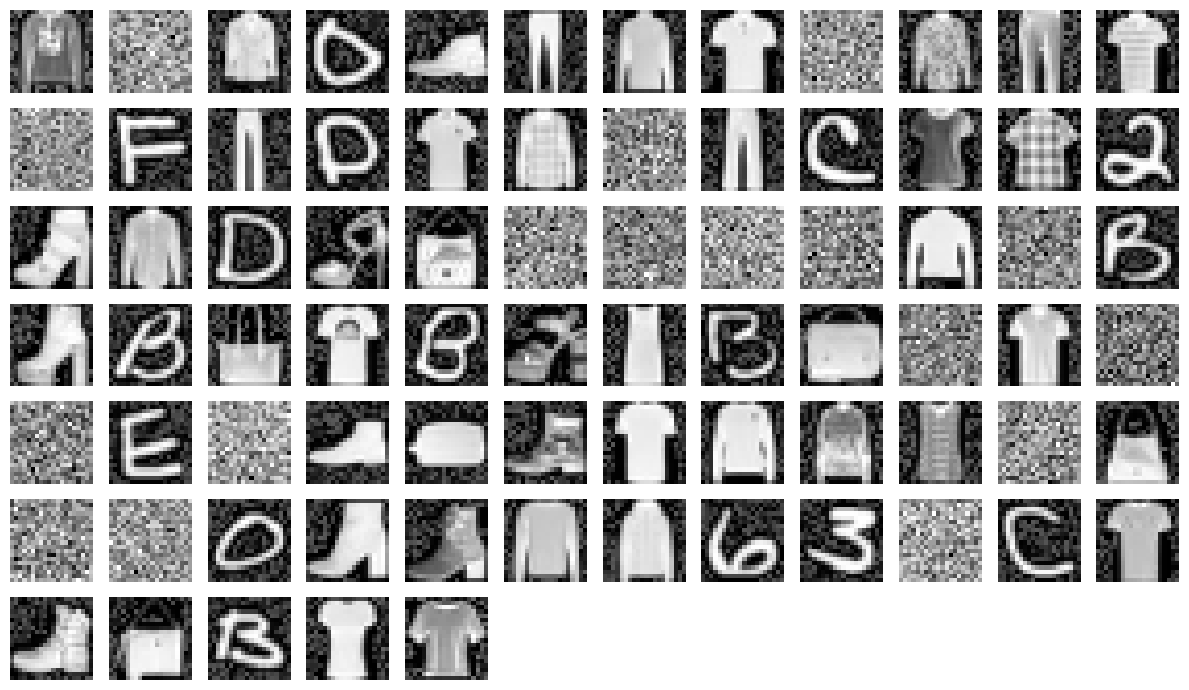

In [122]:
num_images = len(outlier_indices)
cols = 12
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
axes = axes.flatten()
for i, idx in enumerate(outlier_indices):
    image = X_corrupted[idx].reshape(20, 20)
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

for i in range(len(outlier_indices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()